## DATASET

In [6]:
!pip uninstall datasets
!pip install -U datasets

Found existing installation: datasets 2.14.4
Uninstalling datasets-2.14.4:
  Would remove:
    /usr/local/bin/datasets-cli
    /usr/local/lib/python3.11/dist-packages/datasets-2.14.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/datasets/*
Proceed (Y/n)? y
  Successfully uninstalled datasets-2.14.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_m

In [7]:
# Dataset
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("Ashokajou51/ESConv_Original")
train_dataset = dataset['train']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

train.json:   0%|          | 0.00/8.62M [00:00<?, ?B/s]

valid.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

test.json:   0%|          | 0.00/1.44M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1214 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/195 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/195 [00:00<?, ? examples/s]

In [8]:

print(dataset['train'][0])

{'emotion_type': 'anxiety', 'problem_type': 'job crisis', 'situation': "I am on short term disability and I am afraid I will lose my job if I don't go back soon.", 'dialog': [{'text': 'Hello good afternoon.', 'speaker': 'usr', 'knowledge': '[xReact] happy [xIntent] none [xWant] to say hello [xNeed] none [xEffect] none', 'strategy': None, 'heal': None}, {'text': 'Hi, good afternoon.', 'speaker': 'sys', 'knowledge': None, 'strategy': 'Question', 'heal': '[resp] Be nice to people. [str] fuck, fuuuuuuuuuuuuuuuuuuck, fuckkk, fuuuuuuuuck, gt [aff] Joyful'}, {'text': "I'm feeling anxious that I am going to lose my job.", 'speaker': 'usr', 'knowledge': '[xReact] worried [xIntent] none [xWant] to get a new job [xNeed] none [xEffect] frowns', 'strategy': None, 'heal': None}, {'text': 'Losing a job is always anxious.', 'speaker': 'sys', 'knowledge': None, 'strategy': 'Reflection of feelings', 'heal': '[resp] could you get a job? [str] extremy, whenevrt, teachers, ground, havent [aff] Afraid'}, {'

In [9]:
# Pre-processing data for Q&A

import pandas as pd

def extract_qa_from_dialog(dialogue, context_window=3):
    qa_list = []
    for i in range(len(dialogue) - 1):
        current = dialogue[i]
        next_ = dialogue[i + 1]
        if current["speaker"] == "usr" and next_["speaker"] == "sys":
            question = current["text"].strip()
            answer = next_["text"].strip()

            if any(k in question.lower() or k in answer.lower()
                   for k in ["depression", "anxiety", "sad", "stress", "therapy", "support", "lonely", "feel"]):
                context_turns = dialogue[max(0, i - context_window):i]
                context = " ".join([t["text"] for t in context_turns if t["speaker"] == "usr"]).strip()
                input_text = f"mental_health: {question} context: {context}"
                qa_list.append({"input_text": input_text, "target_text": answer})
    return qa_list


# Extract QA pairs
from tqdm import tqdm

qa_all = []

for item in tqdm(dataset['train']):
    dialog = item.get("dialog", [])
    qa_pairs = extract_qa_from_dialog(dialog)
    qa_all.extend(qa_pairs)

qa_df = pd.DataFrame(qa_all)

print(f"Extracted {len(qa_df)} QA pairs.")
print(qa_df.head())


100%|██████████| 1214/1214 [00:00<00:00, 1304.07it/s]

Extracted 4389 QA pairs.
                                          input_text  \
0  mental_health: I'm feeling anxious that I am g...   
1  mental_health: Yes! 100%. Every time my phone ...   
2  mental_health: Thank you for saying that. That...   
3  mental_health: well as I stated above my fathe...   
4  mental_health: thank you! I find myself so str...   

                                         target_text  
0                    Losing a job is always anxious.  
1  No you should not have to feel you made a mist...  
2  You know yourself more than anybody and you ne...  
3  So sorry to hear about your plight. Life is a ...  
4  I understand your concerns about being stresse...  


## Visualizations

In [ ]:
qa_df.describe()

,input_text,target_text
count,4389,4389
unique,3241,3247
top,mental_health: hello context:,You are very welcome.
freq,7,4


In [ ]:
qa_df.shape

(4389, 2)

In [ ]:
# Check for null values
qa_df.isnull().sum()

,0
input_text,0
target_text,0


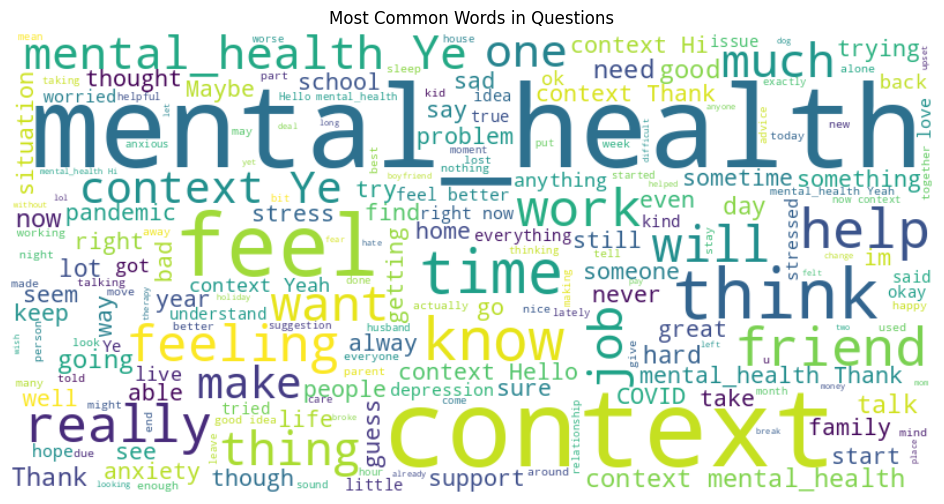

In [ ]:
# Words used the most
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all questions into one string
all_questions = " ".join(q for q in qa_df['input_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_questions)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Questions")
plt.show()

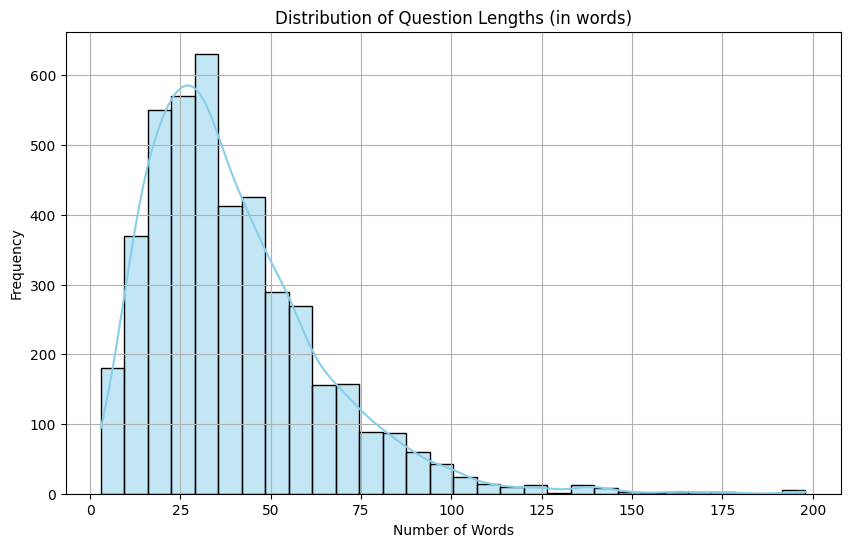

In [ ]:
# Lengths of questions
import seaborn as sns

# Calculate number of words per question
qa_df['question_length'] = qa_df['input_text'].apply(lambda x: len(str(x).split()))

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(qa_df['question_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Question Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Pre-processing

In [10]:
# Text cleaning
import re

def clean_text(text):
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    return text

qa_df["input_text"] = qa_df["input_text"].apply(clean_text)
qa_df["target_text"] = qa_df["target_text"].apply(clean_text)


In [11]:
print(qa_df[['input_text', 'target_text']].head())

                                          input_text  \
0  mental_health: I'm feeling anxious that I am g...   
1  mental_health: Yes! 100%. Every time my phone ...   
2  mental_health: Thank you for saying that. That...   
3  mental_health: well as I stated above my fathe...   
4  mental_health: thank you! I find myself so str...   

                                         target_text  
0                    Losing a job is always anxious.  
1  No you should not have to feel you made a mist...  
2  You know yourself more than anybody and you ne...  
3  So sorry to hear about your plight. Life is a ...  
4  I understand your concerns about being stresse...  


In [12]:
# Loading the tokenizer
from transformers import T5Tokenizer, TFAutoModelForSeq2SeqLM

model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [13]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
train_df, val_df = train_test_split(qa_df[['input_text', 'target_text']], test_size=0.2, random_state=42)

In [14]:
# Tokenizing input and output

from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from datasets import Dataset
from transformers import DataCollatorForSeq2Seq


# Convert to HG Dataset
ds_train = Dataset.from_pandas(train_df[['input_text', 'target_text']])
ds_val = Dataset.from_pandas(val_df[['input_text', 'target_text']])

# Tokenize function
def tokenize_function(examples):
    model_inputs = tokenizer(
        examples["input_text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )
    labels = tokenizer(
        examples["target_text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = ds_train.map(tokenize_function, batched=True)
tokenized_val = ds_val.map(tokenize_function, batched=True)


Map:   0%|          | 0/3511 [00:00<?, ? examples/s]

Map:   0%|          | 0/878 [00:00<?, ? examples/s]

In [15]:
# Create TF Datasets
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors='tf')

tf_train = tokenized_train.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator
)

tf_val = tokenized_val.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    batch_size=8,
    collate_fn=data_collator
)

In [ ]:
!pip uninstall keras -y
!pip install keras==2.11


Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires keras>=3.5.0, but you have keras 2.11.0 which is incompatible.


In [16]:
import tensorflow as tf

# Training the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(
    optimizer=optimizer,
)

history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

Epoch 1/5
439/439 [==============================] - 156s 271ms/step - loss: 2.0641 - val_loss: 0.9793
Epoch 2/5
439/439 [==============================] - 118s 268ms/step - loss: 1.0476 - val_loss: 0.9043
Epoch 3/5
439/439 [==============================] - 117s 266ms/step - loss: 0.9685 - val_loss: 0.8478
Epoch 4/5
439/439 [==============================] - 118s 268ms/step - loss: 0.9091 - val_loss: 0.7858
Epoch 5/5
439/439 [==============================] - 117s 266ms/step - loss: 0.8463 - val_loss: 0.7521


In [ ]:
# Saving the model and its tokenizer
model.save_pretrained("mental_health_qa_model")
tokenizer.save_pretrained("mental_health_qa_tokenizer")

('mental_health_qa_tokenizer/tokenizer_config.json',
 'mental_health_qa_tokenizer/special_tokens_map.json',
 'mental_health_qa_tokenizer/spiece.model',
 'mental_health_qa_tokenizer/added_tokens.json')

In [44]:
from google.colab import files
uploaded = files.upload()

Saving chatbot.ipynb to chatbot.ipynb


In [3]:
# Load the tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mental_health_qa_tokenizer")


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [4]:
# Load the model
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained("mental_health_qa_model")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at mental_health_qa_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [5]:
# Testing the trained model
def generate_response(model, tokenizer, input_text):
    """
    Takes input text (e.g., 'mental_health: I feel so alone lately'),
    tokenizes it, and generates a response using beam search.
    """
    # Tokenize input
    inputs = tokenizer(
        input_text,
        return_tensors="tf",
        truncation=True,
        max_length=64,
        padding="max_length"
    )

    # Generate response
    outputs = model.generate(
        inputs["input_ids"],
        max_length=32,
        num_beams=5,
        early_stopping=True,
        no_repeat_ngram_size=2,
        temperature=0.7,
        do_sample=True
    )

    # Decode and return result
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [6]:
sample_input = "mental_health: I feel so alone lately"
response = generate_response(model, tokenizer, sample_input)

print("User:", sample_input)
print("Chatbot:", response)

User: mental_health: I feel so alone lately
Chatbot: I'm sorry to hear that. I have been feeling so alone lately that I feel the same way.


In [18]:
# Evaluation using BLEU

from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

batch_size = 16  # Adjust based on memory
inputs = val_df['input_text'].tolist()
references = val_df['target_text'].tolist()

candidates = []

for i in tqdm(range(0, len(inputs), batch_size)):
    batch = inputs[i:i+batch_size]
    encoded = tokenizer(batch, return_tensors='tf', padding=True, truncation=True)
    outputs = model.generate(**encoded)
    decoded = [tokenizer.decode(out, skip_special_tokens=True) for out in outputs]
    candidates.extend(decoded)


bleu_scores = [
    sentence_bleu([ref.split()], cand.split())
    for ref, cand in zip(references, candidates)
]

avg_bleu = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", avg_bleu)



  0%|          | 0/55 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:836: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 55/55 [03:14<00:00,  3.53s/it]

Average BLEU Score: 0.0025173363310809884



/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(

In [ ]:
!pip install gradio

In [7]:
# UI interface using gradio
import gradio as gr

def chatbot_interface(input_text):
    response = generate_response(model, tokenizer, input_text)
    return response

iface = gr.Interface(
    fn=chatbot_interface,
    inputs="text",
    outputs="text",
    title="🧠 Mental Health Support Chatbot",
    description="Get empathetic support based on your message."
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c86fa6fb85966df422.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


KeyboardInterrupt: 

In [8]:
!git config --global user.email "munezeroeliane761@gmail.com"
!git config --global user.name "Eliane-M"


In [14]:
!git clone https://github.com/Eliane-M/mental_health_chatbot.git

Cloning into 'mental_health_chatbot'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [16]:
!cp -r mental_health_qa_model/ mental_health_chatbot/
!cp -r mental_health_qa_tokenizer/ mental_health_chatbot/


In [47]:
!cp chatbot.ipynb mental_health_chatbot/
%cd mental_health_chatbot

cp: cannot stat 'chatbot.ipynb': No such file or directory
/content/mental_health_chatbot


In [46]:
%ls /content

mental_health_chatbot/   mental_health_qa_tokenizer/
mental_health_qa_model/  sample_data/


In [29]:
!cp "chatbot.ipynb" "mental_health_chatbot/chatbot.ipynb"

cp: cannot stat 'chatbot.ipynb': No such file or directory


In [17]:
# Commiting and pushing to git
%cd mental_health_chatbot
!git add .
!git commit -m "Add trained model and tokenizer"

/content/mental_health_chatbot
[main 551e457] Add trained model and tokenizer
 7 files changed, 1234 insertions(+)
 create mode 100644 mental_health_qa_model/config.json
 create mode 100644 mental_health_qa_model/generation_config.json
 create mode 100644 mental_health_qa_model/tf_model.h5
 create mode 100644 mental_health_qa_tokenizer/added_tokens.json
 create mode 100644 mental_health_qa_tokenizer/special_tokens_map.json
 create mode 100644 mental_health_qa_tokenizer/spiece.model
 create mode 100644 mental_health_qa_tokenizer/tokenizer_config.json
Enumerating objects: 12, done.
Counting objects: 100% (12/12), done.
Delta compression using up to 2 threads
Compressing objects: 100% (11/11), done.
Writing objects: 100% (11/11), 290.51 MiB | 5.76 MiB/s, done.
Total 11 (delta 0), reused 0 (delta 0), pack-reused 0
remote: error: Trace: 140556b03969b21bd3cb4f66851fd151cec6375af9819a3589e89c0ea66411e2
remote: error: See https://gh.io/lfs for more information.
remote: error: File mental_healt